# End to End Multi-class Dog brees classification

This notebook builds an end-to-end multi-class image classifier using Tnesorflow 2.0 and Tensorflow Hub.

## 1. Problem
When I'm at the cafe and I take a pic of a dog, I want to know what breed of dog it is.

## 2. Data

The data I'm using is from Kaggle's dog breed indentification competition.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this mean there are 120 classes).
* There are around 10000+ images in the training set (these images have label).
* There are around 10000+ images in the test set(these images have no labels, because we'll want to predict them.)

In [0]:
# Unzip the uploaded data into Google Drive
# !unzip "drive/My Drive/Data Science & ML/data/dog-breed-identification.zip" -d "drive/My Drive/Data_Science_ML/data/Dog_Vision/"

## Get our workspace ready

In [109]:
# Import Tensorflow into Colab
import tensorflow as tf
# Import Tensorflow Hub
import tensorflow_hub as hub
print("Tensor flow version:", tf.__version__)
print("Tensor flow version:", hub.__version__)

# Check for GPU Availability
print("GPU", "available (Yes!!!!) " if tf.config.list_physical_devices("GPU") else "not available")

Tensor flow version: 2.2.0-rc2
Tensor flow version: 0.8.0
GPU available (Yes!!!!) 


## Getting our data ready(turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doint first. Turning our images into Tensors(Numerical representations).

Let's start by accessing our data and checking out the labels.

In [110]:
# Checkout label of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Data_Science_ML/data/Dog_Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     605bb5c3c8006441a932f2e880a843da  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [111]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

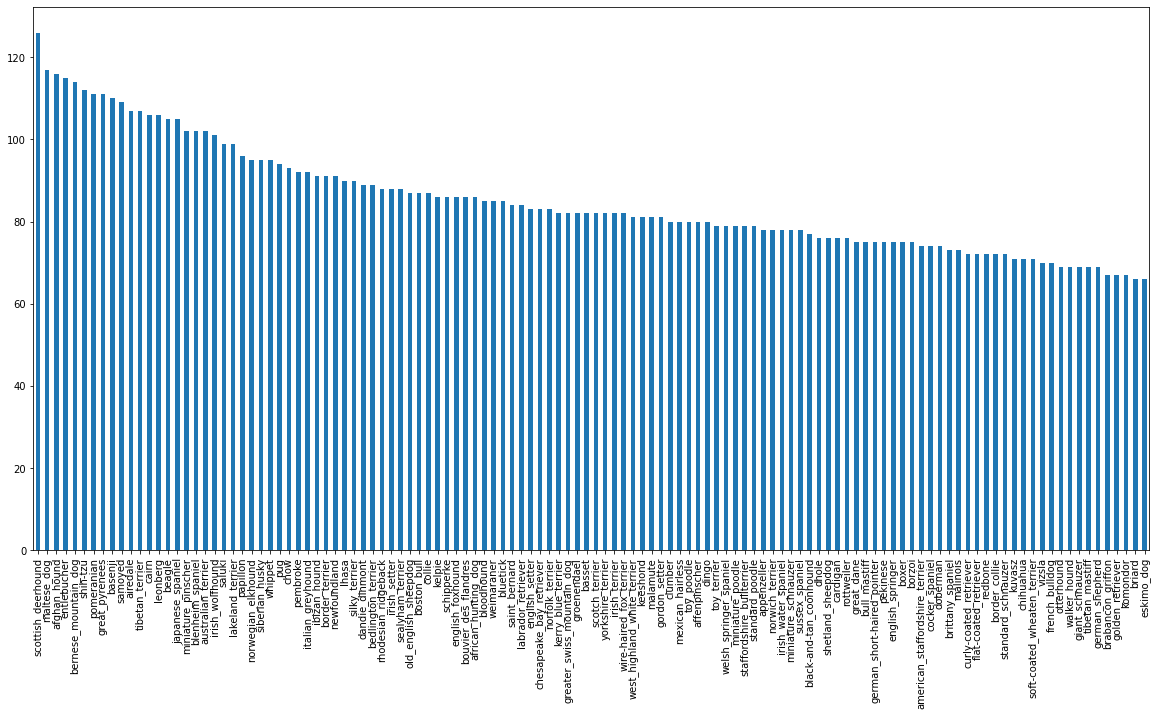

In [112]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [113]:
labels_csv["breed"].value_counts().median()

82.0

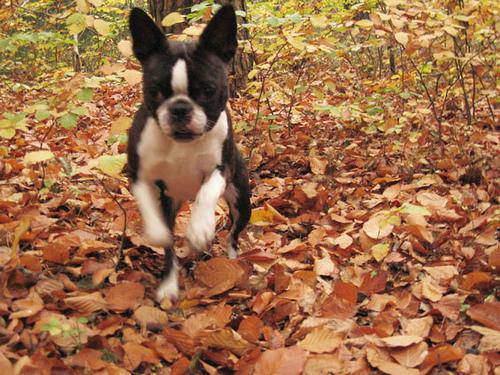

In [114]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Data_Science_ML/data/Dog_Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

# Getting images and their label.

Let's get a list of all our image file pathnames.

In [115]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Data_Science_ML/data/Dog_Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Data_Science_ML/data/Dog_Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [116]:
# Check wheather number of filenames matches number of actual image files
import os
if (len(os.listdir("drive/My Drive/Data_Science_ML/data/Dog_Vision/train/"))) == len(filenames):
    print("Filenames match actual amount of files!!! Proceed.")
else:
    print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


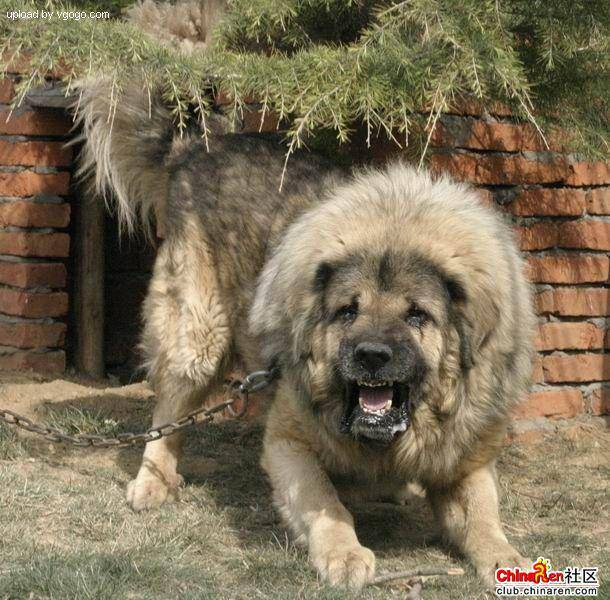

In [117]:
Image(filenames[9000])

In [118]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we have now got our training image filepaths in a list, let's prepare our labels.

In [119]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels
len(labels)

10222

In [120]:
# See number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames!!!")
else:
    print("Number of labels does not match number of filenames")

Number of labels matches number of filenames!!!


In [121]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [122]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [15]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
len(boolean_labels)

10222

In [18]:
# Example: turning boolean array into integers
print(labels[0])  # original label
print(np.where(unique_breeds == labels[0]))  # index where label occurs
print(boolean_labels[0].argmax())  # index where label occurs in boolean array
print(boolean_labels[0].astype(int))  # there will be 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# Creating our own validation set
> Since the dataset from kaggle doesn't come with a validation set, we're going to create our own.

In [0]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [21]:
len(filenames)

10222

We're going to start off experimenting with ~1000 images and increase as needed

In [0]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [23]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=.2,
                                                  random_state=42
                                                  )

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [25]:
# Let's have a geez at the training data
X_train[:5], y_train[:5]

(['drive/My Drive/Data_Science_ML/data/Dog_Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Data_Science_ML/data/Dog_Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, Fals

## Preprocessing our Images (Turning images into Tensors)

To preprocess our images into Tensors, we are going to write a function which does a few things:

1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (jpg) into Tensors.
4. Resize the `image` to be a shape of (224, 224).
5. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [26]:
# Convert image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [27]:
image.max(), image.min()

(255, 0)

In [28]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [29]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [30]:
# turn image into tensors
tf.constant

<function tensorflow.python.framework.constant_op.constant>

Now we have seen what an image looks like as a Tensor, let's make a function to preprocess image.

1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (jpg) into Tensors.
4. Normalize our image (convert colour channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224).
6. Return the modified `image`

In [0]:
# Define image size
IMAGE_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, IMG_SIZE=IMAGE_SIZE):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image

In [0]:
# tensor = tf.io.read_file(filenames[26])
# tensor

In [0]:
# tensor = tf.image.decode_jpeg(tensor, channels=3)
# tensor

In [0]:
# tf.image.convert_image_dtype(tensor, tf.float32)

# Turning our Data into batches

Why turn our data into batches?

Let's say you're trying to process 10000+ images in one go... they all might not fit into memory.

So that's why we do about 32(this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use Tensorflow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`

In [0]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label, processes the 
    image and returns a type of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [36]:
# Demo of above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we have got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`x` & `y`) into batches!

In [0]:
# Define the batch size, 32 is a good start
# Tensor flow default batch_size is also 32 even though we are defining here
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False,
                        test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle it if it's 
    validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))  # only filepaths (no labels)
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # If the data is valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths
                                                   tf.constant(y)))  # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function
        # faster than shuffling images
        data = data.shuffle(buffer_size=len(X))
        
        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [38]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [39]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [40]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

# Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [0]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Display a plot of 25 images and their labels from a data batch.
    """
    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")

In [42]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [43]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.5705322 , 0.33588538, 0.15008473],
          [0.66901225, 0.4601166 , 0.26022965],
          [0.61062384, 0.43763596, 0.21601713],
          ...,
          [0.8182312 , 0.7297958 , 0.26963907],
          [0.72454786, 0.6059109 , 0.2653059 ],
          [0.7494603 , 0.6252918 , 0.32456532]],
 
         [[0.6761415 , 0.4733761 , 0.30642927],
          [0.5672121 , 0.38192675, 0.20349538],
          [0.5883547 , 0.4322571 , 0.2403155 ],
          ...,
          [0.9326942 , 0.8260503 , 0.41093278],
          [0.86072475, 0.74250627, 0.3694122 ],
          [0.76781666, 0.6461604 , 0.29291284]],
 
         [[0.46350825, 0.29595745, 0.1536156 ],
          [0.42554107, 0.27039403, 0.12009468],
          [0.7887875 , 0.6547362 , 0.49015   ],
          ...,
          [0.89372385, 0.7696401 , 0.41811958],
          [0.88609535, 0.7585918 , 0.36495727],
          [0.8243601 , 0.69494826, 0.2930575 ]],
 
         ...,
 
         [[0.7344025 , 0.4716574 , 0.2559711 ],
          [0.71372

In [44]:
len(train_images), len(train_labels)

(32, 32)

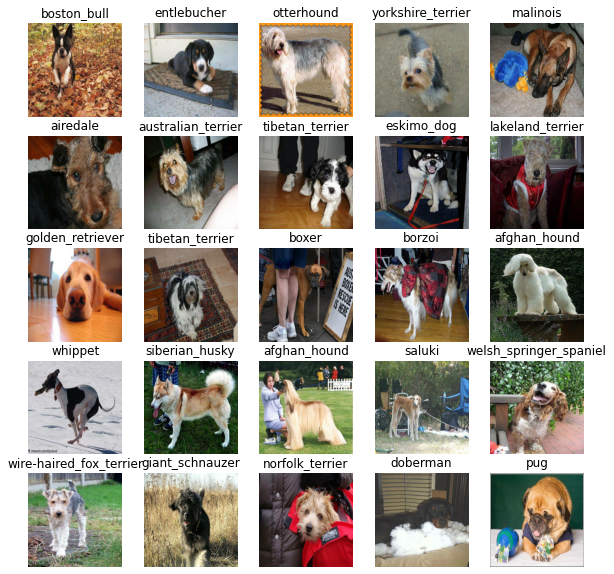

In [45]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

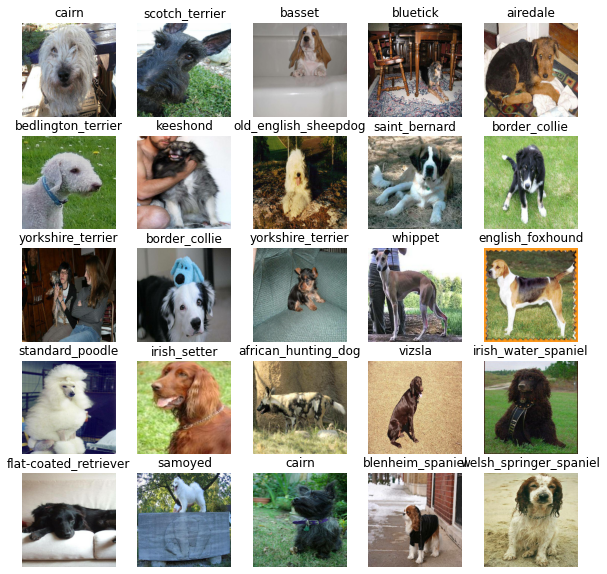

In [46]:
# Now let's visualize validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Bulding the model  

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* the out put shape(image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.
* The URL of the model we want to use from Tensorflow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


Now we have got our input, outputs and model ready to go.
Let's put them together into Keras deep learning model!!!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Return the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras

In [0]:
#  Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                              activation="softmax") # Layer 2 (output layer)
    ])

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model

In [49]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [50]:
outputs = np.ones(shape=(1, 1, 1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard call back which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

In [0]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a TensorBoardcallback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("drive/My Drive/Data_Science_ML/data/Dog_Vision/logs",
                          # Make it so the logs get tracked whenever we run an experinment
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [0]:
# Create early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [56]:
# Check to make sure we'll still running on a  GPU
print("GPU", "available (Yes!!!)") if tf.config.list_physical_devices("GPU") else "not available :("

GPU available (Yes!!!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
* Return the model

In [0]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              validation_freq=1,
              callback=[tensorboard, early_stopping])
    # Return the fitted model
    return model

In [58]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 465s 19s/step - loss: 4.6059 - accuracy: 0.0887 - val_loss: 3.3938 - val_accuracy: 0.2800
Epoch 2/100
25/25 [==============================] - 7s 273ms/step - loss: 1.6732 - accuracy: 0.6687 - val_loss: 2.1647 - val_accuracy: 0.5250
Epoch 3/100
25/25 [==============================] - 7s 279ms/step - loss: 0.5818 - accuracy: 0.9287 - val_loss: 1.6612 - val_accuracy: 0.6100
Epoch 4/100
25/25 [==============================] - 7s 286ms/step - loss: 0.2541 - accuracy: 0.9862 - val_loss: 1.4809 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 7s 291ms/step - loss: 0.1477 - accuracy: 0.9975 - val_loss: 1.4160 - val_accuracy: 0.6300
Epoch 6/100
25/25 [==============================] - 8s 310ms/step - loss: 0.1017 - accuracy: 1.0000 - val_loss: 1.3540 - val_accuracy: 0.6400
Epoch 7/100
25/25 [==============================

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model Overfitting in deep learning nueral networks?

**Note:** Overfitting to begin with is a good thing! It means our model is learning!!!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [59]:
%tensorboard --logdir drive/My\ Drive/Data_Science_ML/data/Dog_Vision/logs

<IPython.core.display.Javascript object>

# Making and Evaluating predictions using a trained model

In [60]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [61]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 170ms/step


array([[6.7449611e-04, 3.0931126e-06, 3.6412236e-04, ..., 4.8299591e-04,
        8.9673779e-07, 2.3289231e-04],
       [4.9897946e-05, 3.3943819e-05, 2.8458759e-04, ..., 3.0794927e-05,
        4.2194406e-05, 2.9720118e-06],
       [2.3821185e-06, 2.3697517e-06, 1.2538239e-06, ..., 4.6274286e-06,
        7.0289968e-07, 6.1801875e-05],
       ...,
       [1.2256535e-07, 5.4728457e-07, 2.5121369e-06, ..., 2.5273926e-07,
        1.0880842e-05, 6.5958295e-07],
       [7.5464492e-04, 7.2736460e-05, 9.7072343e-06, ..., 2.3765926e-04,
        3.8912881e-06, 7.3925210e-03],
       [4.3537835e-05, 8.0093196e-06, 1.4565552e-04, ..., 3.9200969e-03,
        5.8269815e-04, 8.1763710e-07]], dtype=float32)

In [0]:
# predictions.shape

In [0]:
# len(y_val)

In [0]:
# len(unique_breeds)

In [0]:
# len(predictions[0])

In [0]:
# np.sum(predictions[0])

In [0]:
# np.sum(predictions[1])

In [68]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.68715396e-05 3.05991193e-06 1.29231457e-05 5.98908582e-06
 1.24956481e-04 6.65383823e-06 1.12793117e-04 1.29097869e-04
 2.27930420e-03 1.11193527e-02 5.17428589e-06 2.50443833e-07
 6.01168067e-05 3.63864633e-03 1.82985459e-04 7.37003982e-04
 2.47300864e-06 1.30973958e-05 2.35235439e-05 7.16219947e-05
 2.11348174e-06 5.59929322e-05 2.95207133e-06 3.28007127e-06
 1.99860893e-03 4.68867347e-06 2.51385336e-06 8.29137753e-06
 2.33970004e-05 1.71672673e-06 7.74335660e-07 1.40055781e-05
 1.55971748e-06 3.60313038e-06 3.01424848e-06 1.69743203e-06
 1.71966876e-05 2.82640267e-05 6.67282620e-06 1.65508196e-01
 1.61434909e-05 1.79409062e-06 9.35516437e-04 3.37616342e-07
 1.21897438e-05 2.11249221e-06 2.46734198e-05 2.18555520e-04
 6.54829137e-07 4.88670230e-05 1.40934471e-05 9.73681563e-06
 1.44156411e-05 8.20930218e-05 2.79436108e-07 6.58644058e-05
 2.97615697e-05 3.16009255e-06 6.00599378e-06 1.49204891e-06
 8.42947702e-06 1.18758377e-04 4.25276028e-07 1.19796334e-06
 1.29273985e-05 1.498142

In [69]:
unique_breeds[113]

'walker_hound'

Having the above functionality is great but we want to be able to do it scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [70]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'golden_retriever'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to validation labels (truth labels).

In [71]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [72]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and label.
    """
    images = []
    labels = []
    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[90]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [73]:
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)

images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [74]:
get_pred_label(labels_[0])

'cairn'

Now we've got ways to  get:

* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visualize.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer.
* Convert the prediction probabilites to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target images on a single plot.

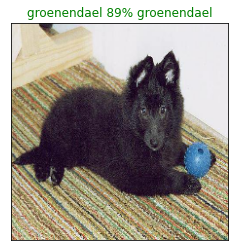

In [75]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the colour of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"


    # Change plot title to be predicted, probabilities of prediction and truth label
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)
    
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions:

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
    * Prediction probabilities indexes
    * Prediction probabilities values
    * Prediction labels
* Plot the top 10 prediction probability values and labels, colouring the true label green

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plus the top 10 highest prediction confidence along with the truth label for sample n.
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values,
                       color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")
    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("red")
    else:
        pass

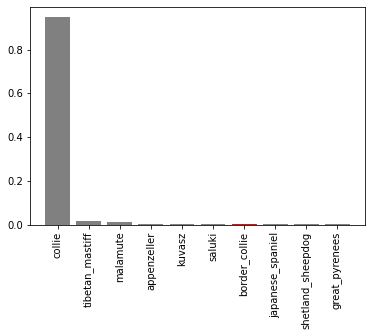

In [77]:
plot_pred_conf(prediction_probabilities=predictions, labels=val_labels, n=9)

In [0]:
# predictions[0][predictions[0].argsort()[-10:][::-1]]

In [0]:
# predictions[0].max()

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.

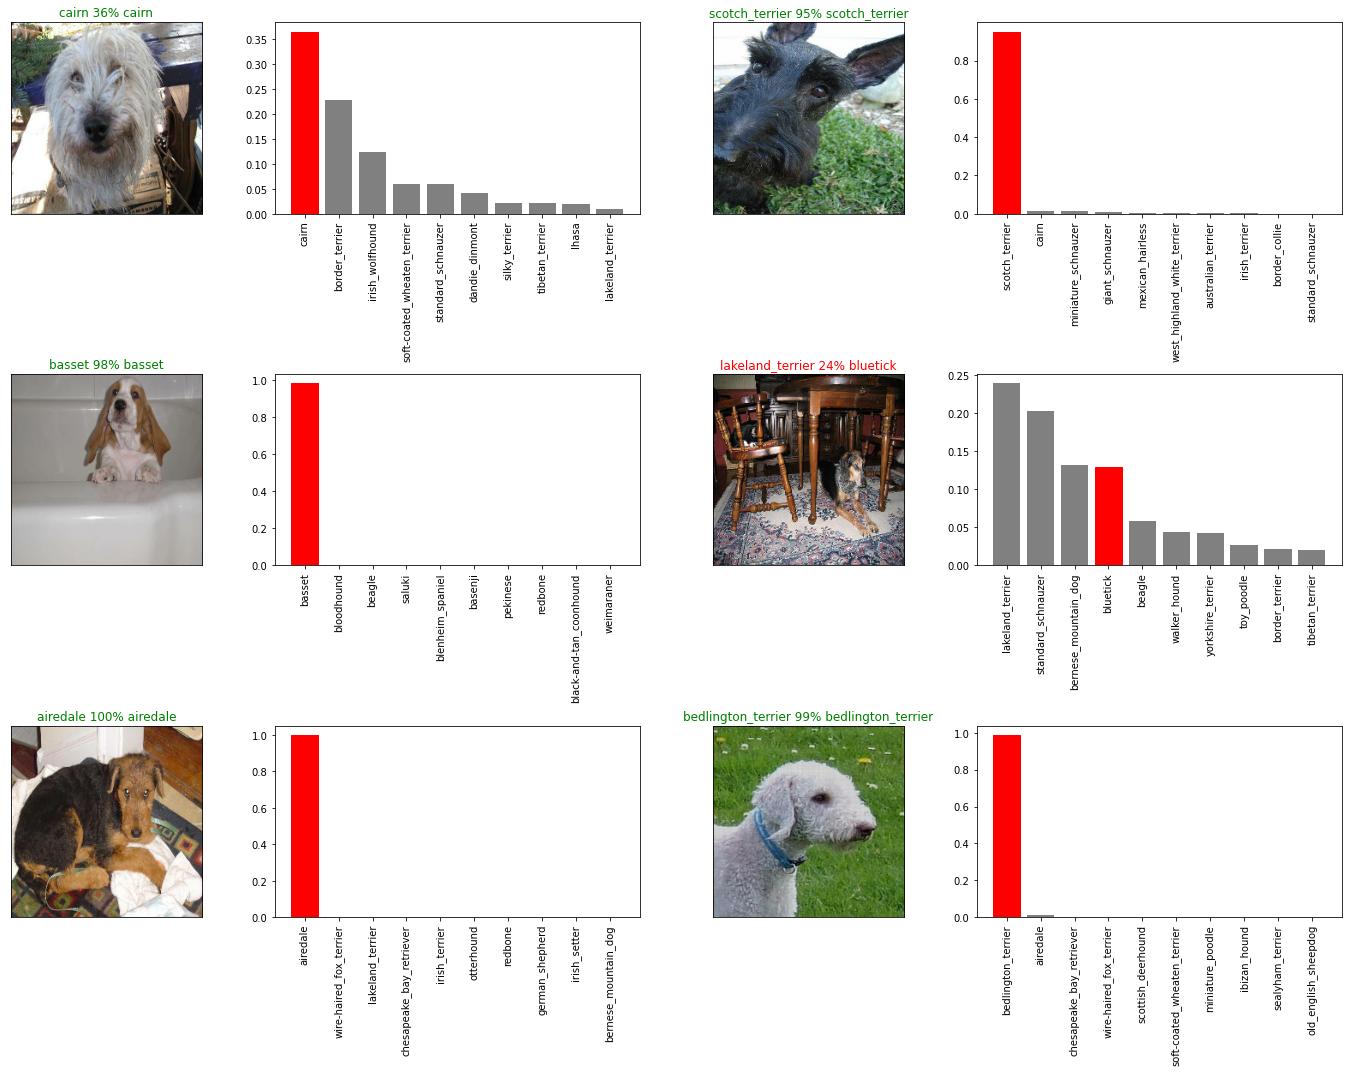

In [80]:
# Let's check out a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols= 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=predictions,
              labels=val_labels,
              images=val_images,
              n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=predictions,
                   labels=val_labels,
                   n=i+i_multiplier)
    plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true labels?

## Saving and reloading a trained model

In [0]:
# Create a function to save a model
def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (string).
    """
    # Create a model directory pathname with current time
    modeldir = os.path.join("drive/My Drive/Data_Science_ML/data/Dog_Vision/models",
                            datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = modeldir + "-" + suffix + ".h5" # save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path

In [0]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model from a specified path.
    """
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                       custom_objects={"KerasLayer": hub.KerasLayer})
    return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [83]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Data_Science_ML/data/Dog_Vision/models/20200415-14411586961716-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Data_Science_ML/data/Dog_Vision/models/20200415-14411586961716-1000-images-mobilenetv2-Adam.h5'

In [84]:
# Load a trained model
loaded_1000_image_model = load_model("drive/My Drive/Data_Science_ML/data/Dog_Vision/models/20200415-14411586961716-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/My Drive/Data_Science_ML/data/Dog_Vision/models/20200415-14411586961716-1000-images-mobilenetv2-Adam.h5


In [85]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 174ms/step - loss: 1.1997 - accuracy: 0.6700


[1.1996691226959229, 0.6700000166893005]

In [86]:
# Evaluate the model loaded
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 197ms/step - loss: 1.1997 - accuracy: 0.6700


[1.1996691226959229, 0.6700000166893005]

# Training a big dog model (on the full data)

In [87]:
len(X), len(y)

(10222, 10222)

In [88]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [89]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [90]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor vaalidation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while(may be upto 30 minutes for the first epoch) because GPU we're using in the runtime has to load all of the images into memory.

In [92]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 6400s 20s/step - loss: 1.3324 - accuracy: 0.6681
Epoch 2/100
320/320 [==============================] - 80s 249ms/step - loss: 0.3960 - accuracy: 0.8857
Epoch 3/100
320/320 [==============================] - 86s 268ms/step - loss: 0.2357 - accuracy: 0.9358
Epoch 4/100
320/320 [==============================] - 85s 265ms/step - loss: 0.1546 - accuracy: 0.9623
Epoch 5/100
320/320 [==============================] - 76s 237ms/step - loss: 0.1053 - accuracy: 0.9782
Epoch 6/100
320/320 [==============================] - 83s 259ms/step - loss: 0.0772 - accuracy: 0.9862
Epoch 7/100
320/320 [==============================] - 84s 262ms/step - loss: 0.0595 - accuracy: 0.9913
Epoch 8/100
320/320 [==============================] - 85s 265ms/step - loss: 0.0459 - accuracy: 0.9947
Epoch 9/100
320/320 [==============================] - 86s 269ms/step - loss: 0.0384 - accuracy: 0.9956
Epoch 10/100
320/320 [==============================] - 78s 245m

In [94]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Data_Science_ML/data/Dog_Vision/models/20200415-17001586970008-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Data_Science_ML/data/Dog_Vision/models/20200415-17001586970008-full-image-set-mobilenetv2-Adam.h5'

In [95]:
# Load in the full model
loaded_full_model = load_model('drive/My Drive/Data_Science_ML/data/Dog_Vision/models/20200415-17001586970008-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Data_Science_ML/data/Dog_Vision/models/20200415-17001586970008-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (Since the test data doesn't have labels).
* Make a predictions array by passing the test batches to `predict()` method called on our model.

In [96]:
# Load test image filenames
test_path = "drive/My Drive/Data_Science_ML/data/Dog_Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Data_Science_ML/data/Dog_Vision/test/ea5977763e3e8b39f8ea8c28565d32e3.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/test/f569c5b12fae4ca37d376d21bc05f2b3.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/test/eebf49093e7b0c603ee4c8d67d061352.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/test/ef395765458ead37cdb9513cf76b9baa.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/test/f398e8ff747bfbb95f4aa7660608fc4f.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/test/eda1edd004eb4311a73cf7cd0bfa31dc.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/test/f1eadf24d904d3c1e26d8081555901be.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/test/f4496b7d4565b8bdebe844229a339796.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/test/e8b49a4b2c22d3c5cb3c88c61654e991.jpg',
 'drive/My Drive/Data_Science_ML/data/Dog_Vision/test/ea8669c09612478bfa202ae2fa101b13.jpg']

In [98]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [99]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about an ~1hr)

In [100]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose=1)

324/324 [==============================] - 6956s 21s/step


In [0]:
# Save predictions (Numpy array) to csv file (for access later)
np.savetxt("drive/My Drive/Data_Science_ML/data/Dog_Vision/pred_array.csv", test_predictions, delimiter=",")

In [0]:
# Load predictions (Numpy array) from csv
test_predictions = np.loadtxt("drive/My Drive/Data_Science_ML/data/Dog_Vision/pred_array.csv", delimiter=",")

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breeds.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test images ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [123]:
# Create a pandas DataFrame with Empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [0]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [125]:
preds_df.head()

id  ... yorkshire_terrier
0  ea5977763e3e8b39f8ea8c28565d32e3  ...               NaN
1  f569c5b12fae4ca37d376d21bc05f2b3  ...               NaN
2  eebf49093e7b0c603ee4c8d67d061352  ...               NaN
3  ef395765458ead37cdb9513cf76b9baa  ...               NaN
4  f398e8ff747bfbb95f4aa7660608fc4f  ...               NaN

[5 rows x 121 columns]

In [126]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  ea5977763e3e8b39f8ea8c28565d32e3  ...       1.94831e-12
1  f569c5b12fae4ca37d376d21bc05f2b3  ...       4.06478e-07
2  eebf49093e7b0c603ee4c8d67d061352  ...       2.21727e-10
3  ef395765458ead37cdb9513cf76b9baa  ...       7.35116e-11
4  f398e8ff747bfbb95f4aa7660608fc4f  ...       3.25456e-11

[5 rows x 121 columns]

In [0]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/My Drive/Data_Science_ML/data/Dog_Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of your own images.
* Turn the filepaths into data batches using `create_batch_data()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the prediction labels to the custom images.


In [0]:
# Get custom image filepaths
custom_path = "drive/My Drive/Data_Science_ML/data/dog_pics/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [132]:
custom_image_paths

['drive/My Drive/Data_Science_ML/data/dog_pics/old-english-sheepdog.jpg']

In [133]:
# Turn custom images into batch datasets 
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [135]:
custom_preds.shape

(1, 120)

In [136]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['old_english_sheepdog']

In [0]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

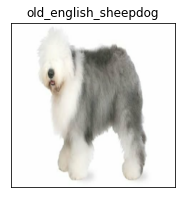

In [138]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)